In [1]:
import numpy as np
import cv2
import timm
import tqdm

import torch
from torchvision import datasets, transforms
from torch.utils import data

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt


np.random.seed(42)
NUM_CLASSES = 9
BATCH_SIZE = 32
device = torch.device("cuda")
PATH_TO_TEST_DATASET = "data/CRC-VAL-HE-7K/"


def cv2_loader(path: str):
    return Image.fromarray(cv2.imread(path, -1)[:, :, ::-1])


def cv2_huen10_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] -= 10
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])


def cv2_hue10_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] += 10
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])

def cv2_huen20_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] -= 20
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])


def cv2_hue20_damage_loader(path: str):
    img = cv2.imread(path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = np.int32(img)
    img[:, :, 0] += 20
    img = np.uint8(np.clip(img, 0, 255))
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    return Image.fromarray(img[:, :, ::-1])

/home/user/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/user/anaconda3/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-07-19 18:13:45.961963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2024-07-19 18:13:45.961978: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from model import DeepCMorph

model = DeepCMorph(num_classes=NUM_CLASSES)
# Loading model weights corresponding to the TCGA Pan Cancer dataset
# Possible dataset values:  TCGA, TCGA_REGULARIZED, CRC, COMBINED
model.load_weights(dataset="CRC")

model.to(device)
model.eval()

Model loaded, unexpected keys: []


DeepCMorph(
  (dropout): Dropout(p=0.0, inplace=False)
  (model_preprocessing): DeepCMorphSegmentationModule(
    (encoder): EfficientNet(
      (features): Module(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Module(
          (0): Module(
            (block): Module(
              (0): Conv2dNormActivation(
                (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
               

In [3]:
def evaluate(model, test_dataloader):
    print("Running Evaluation...")

    targets_array = []
    predictions_array = []

    with torch.no_grad():

        test_iter = iter(test_dataloader)
        for j in tqdm.tqdm(range(len(test_dataloader))):

            image, labels = next(test_iter)
            image = image.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)


            predictions = model(image)
            _, predictions = torch.max(predictions.data, 1)

            predictions = predictions.detach().cpu().numpy()
            targets = labels.detach().cpu().numpy()

            for k in range(targets.shape[0]):

                target = targets[k]
                predicted = predictions[k]

                targets_array.append(target)
                predictions_array.append(predicted)

        print("Accuracy: " + str(accuracy_score(targets_array, predictions_array)))
        print("Balanced Accuracy: " + str(balanced_accuracy_score(targets_array, predictions_array)))
        

        print(classification_report(targets_array, predictions_array))
        print(confusion_matrix(targets_array, predictions_array))
        
        
        return predictions_array

In [4]:
test_transforms = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_no_hue_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [02:27<00:00,  1.53it/s]

Accuracy: 0.96991643454039
Balanced Accuracy: 0.9559323884341416
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1338
           1       1.00      1.00      1.00       847
           2       0.90      1.00      0.95       339
           3       0.98      0.99      0.99       634
           4       0.99      0.99      0.99      1035
           5       0.83      0.95      0.89       592
           6       0.99      0.99      0.99       741
           7       0.97      0.72      0.83       421
           8       0.97      0.99      0.98      1233

    accuracy                           0.97      7180
   macro avg       0.96      0.96      0.96      7180
weighted avg       0.97      0.97      0.97      7180

[[1309    0    0    3    3   23    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    0  338    1    0    0    0    0    0]
 [   0    0    1  626    0    0    0    0    7]
 [   0    0    0    0 1022   10    0  

In [5]:
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_huen10_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_huen10_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [02:29<00:00,  1.50it/s]

Accuracy: 0.9495821727019499
Balanced Accuracy: 0.9337686186470615
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1338
           1       1.00      1.00      1.00       847
           2       0.83      0.99      0.90       339
           3       1.00      0.95      0.98       634
           4       0.99      0.97      0.98      1035
           5       0.73      0.94      0.82       592
           6       0.98      0.99      0.98       741
           7       0.99      0.64      0.78       421
           8       0.97      0.98      0.98      1233

    accuracy                           0.95      7180
   macro avg       0.94      0.93      0.93      7180
weighted avg       0.96      0.95      0.95      7180

[[1252    0    1    2   13   70    0    0    0]
 [   1  846    0    0    0    0    0    0    0]
 [   0    4  335    0    0    0    0    0    0]
 [   0    0   14  605    0    0    1    2   12]
 [   0    0    1    0 1007   20    1

In [6]:
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_hue10_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_hue10_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [02:29<00:00,  1.50it/s]

Accuracy: 0.9646239554317548
Balanced Accuracy: 0.9470389765536864
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1338
           1       1.00      1.00      1.00       847
           2       0.95      1.00      0.97       339
           3       0.97      0.99      0.98       634
           4       0.93      0.99      0.96      1035
           5       0.89      0.88      0.88       592
           6       0.96      0.99      0.98       741
           7       0.94      0.70      0.80       421
           8       0.98      0.98      0.98      1233

    accuracy                           0.96      7180
   macro avg       0.96      0.95      0.95      7180
weighted avg       0.96      0.96      0.96      7180

[[1333    1    1    1    0    2    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    0  338    1    0    0    0    0    0]
 [   0    0    5  628    0    0    0    0    1]
 [   2    2    0    0 1025    2    1

In [7]:
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_huen20_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_huen20_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [02:31<00:00,  1.49it/s]

Accuracy: 0.9125348189415042
Balanced Accuracy: 0.890318852445652
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1338
           1       0.98      1.00      0.99       847
           2       0.82      0.96      0.89       339
           3       1.00      0.90      0.94       634
           4       0.95      0.97      0.96      1035
           5       0.58      0.96      0.72       592
           6       0.97      0.97      0.97       741
           7       0.93      0.44      0.60       421
           8       0.97      0.94      0.96      1233

    accuracy                           0.91      7180
   macro avg       0.91      0.89      0.88      7180
weighted avg       0.94      0.91      0.91      7180

[[1178    0    1    0   53  105    0    0    1]
 [   1  846    0    0    0    0    0    0    0]
 [   0   13  326    0    0    0    0    0    0]
 [   0    0   27  568    0   10    2    8   19]
 [   0    0    1    0  999   24    5 

In [8]:
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms, loader=cv2_hue20_damage_loader)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)

predictions_hue20_aug = evaluate(model, test_dataloader)

Running Evaluation...


100%|████████████████████████████████████████████████████████████████████████████████████████| 225/225 [02:31<00:00,  1.49it/s]

Accuracy: 0.9272980501392758
Balanced Accuracy: 0.9023728963922151
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1338
           1       0.91      1.00      0.95       847
           2       0.95      0.98      0.97       339
           3       0.94      0.98      0.96       634
           4       0.86      0.97      0.91      1035
           5       0.89      0.71      0.79       592
           6       0.94      0.99      0.96       741
           7       0.71      0.57      0.64       421
           8       0.99      0.96      0.97      1233

    accuracy                           0.93      7180
   macro avg       0.91      0.90      0.90      7180
weighted avg       0.93      0.93      0.92      7180

[[1274   60    1    0    0    3    0    0    0]
 [   0  847    0    0    0    0    0    0    0]
 [   0    3  333    3    0    0    0    0    0]
 [   0    1   11  622    0    0    0    0    0]
 [  11   16    0    0 1004    0    1

In [9]:
test_vis_huen20_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=None, loader=cv2_huen20_damage_loader)
test_vis_hue20_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=None, loader=cv2_hue20_damage_loader)
test_vis_no_hue_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=None, loader=cv2_loader)

In [10]:
def plot_pair(title, imgs, texts):
    fig, axes = plt.subplots(nrows=1, ncols=3)
    fig.suptitle(title)
    for img, text, ax in zip(imgs, texts, axes.ravel()):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(text)
    fig.tight_layout()

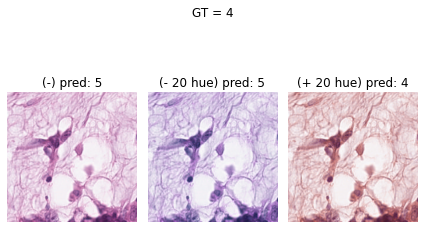

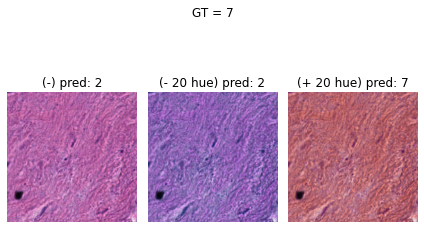

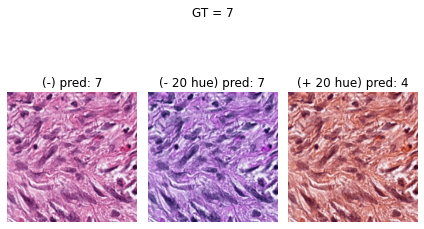

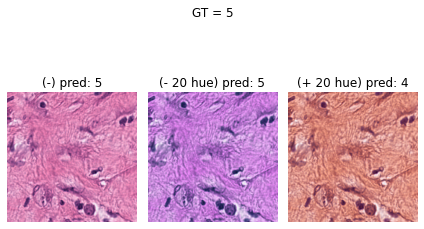

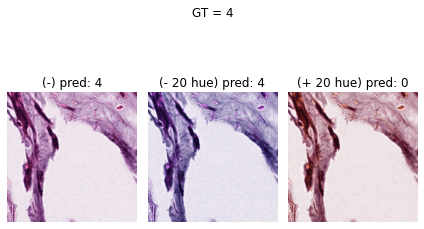

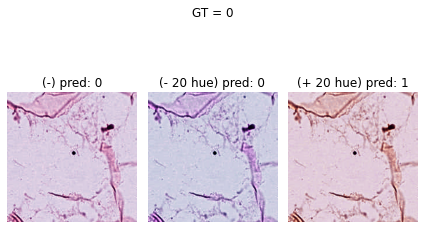

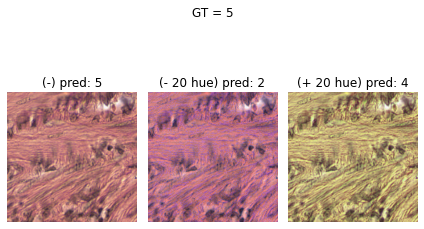

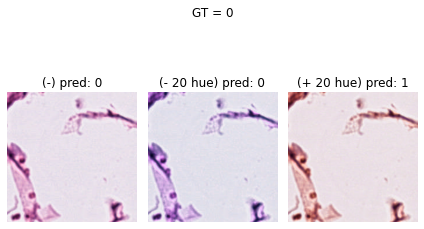

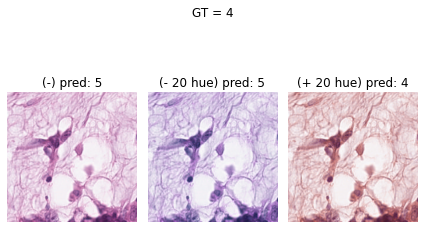

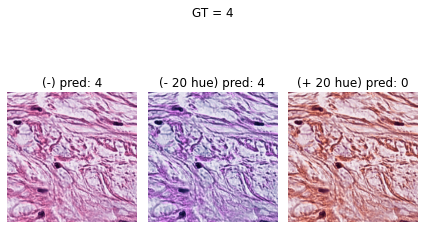

In [11]:
difference = (
    (np.array(predictions_no_hue_aug) != np.array(predictions_hue20_aug)) & 
    (np.array(predictions_hue20_aug) != np.array(predictions_huen20_aug)) 
).nonzero()

for idx in np.random.choice(difference[0], 10):
    plot_pair(
        "GT = " + str(test_vis_no_hue_dataset[idx][1]),
        [test_vis_no_hue_dataset[idx][0], test_vis_huen20_dataset[idx][0], test_vis_hue20_dataset[idx][0]], 
        [
            "(-) pred: " + str(predictions_no_hue_aug[idx]),
            "(- 20 hue) pred: " + str(predictions_huen20_aug[idx]),
            "(+ 20 hue) pred: " + str(predictions_hue20_aug[idx])
        ]
    )